# Zastosowanie metaheurystyk do rozwiązywania problemów planowania projektów z wieloma wymaganymi umiejętnościami i ograniczonymi zasobami

Jednym z klasycznych problemów optymalizacyjnych jest problem harmonogramowania projektów. Wariantem na którym się skupiłem jest problem harmonogramowania projektów z wieloma wymaganymi umiejętnościami i ograniczonymi zasobami. Został on stworzony przez naukowców związanych z Politechniką Wrocławską i można o nim przeczytać m. in. na stronie http://imopse.ii.pwr.wroc.pl/. Jego podstawowe założenia są następujące:
* projekt posiada określoną ilość zadań do wykonania.
* każde zadanie ma określony czas wykonania.
* każdy zasób posiada określone umiejętności na określonym poziomie.
* każdy zadanie ma określoną wymaganą umiejętność na określonym poziomie, aby dany zasób mógł wykonać dane zadanie, musi najpierw posiadać tą umiejętność na równym, lub wyższym poziomie.
* każdy zasób ma określoną stawkę za pracę.
* każde zadanie musi być zrobione bez przerw w pracy pomiędzy.
* każde zadanie musi być zrobione przez tylko jeden zasób.
* każde zadanie może mieć inne zadania jako wymagania które muszą być zakończone, zanim może zostać rozpoczęte.

Problem ten został opracowany razem ze współpracy z inżynierami z firmy Volvo. Dzięki temu jego twórcy dołączają oparte na rzeczywistości, ale zanonimizowane, zestawy danych dla przykładowych projektów. Jest ich 42 - 6 małych problemów i 36 pełnowymiarowych, które posiadają do:
* 200 zadań.
* 150 relacji pomiędzy zadaniami.
* 15 umiejętności na różnych poziomach.
* 40 zasobów.

Problem ten należy do kategorii problemów NP-trudnych, co w praktyce oznacza, że ilość potencjalnych rozwiązań dla nietrywialnych przykładów rośnie w tempie niepozwalającym na użycie klasycznego przeglądu zupełnego rozwiązań - jest ich po prostu zbyt dużo. W związku z tym postanowiłem użyć metaheurystyk. Są to sposoby na stworzenie określonej heurystyki dla danego problemu, która w przeciwieństwie do algorytmu, nie gwarantuje zawsze najlepszego rozwiązania, ale jednocześnie nie wymaga całkowitego przeszukiwania przestrzeni rozwiązań.

Aby je zastosować musiałem zdefiniować reprezentację tego problemu. Najprostszą opcją było by podanie czasu rozpoczęcia każdego zadania, oraz kto ma dane zadanie wykonać. Niestety ten sposób wprowadza możliwość powstania potencjalnych konfilktów jeżeli przypiszemy dwa zadania do jednego zasobu w tym samym czasie - nie będzie on ich w stanie wykonać naraz, zgodnie z założeniami problemu. Aby tego uniknąć, zamiast podawać czas rozpoczęcia, podajemy ich priorytet wykonania, jako zwykła kolejność. Nadal pozostaje potencjalny konfliktów, jeżeli przypiszemy zadanie do zasobu który nie posiada wymaganych umiejętności, ale jest to o wiele łatwiejsze do uniknięcia. Podsumowując nasza reprezentacja problemu składa się z dwóch części:
* listy kolejności wykonywania zadań.
* listy przypisanych zasobów do zadań.

Potrzebowałem także zdefiniować funkcję oceny. W mojej pracy zajmuję sie optymalizacją czasu wykonania, a nie kosztu wymagania - ponieważ stworzenie osobnika z najmniejszą możliwym kosztem może zostać trywialnie rozwiązane przez przydzielenie tylko najtańszych zasobów do zadań. Można także optymalizować po obu kryteriach naraz, tworząc funkcję oceny która przykładowo mogła by być średnią ważoną, ale nie będzie to miało wpływu na trudność problemu. Aby ostatecznie obliczyć czas jakie danemu rozwiązaniu zajmie projekt zastosowałem następujący algorytm:
1. Dla każdego zadania:
    1. Sprawdź czy zadania które musiały się zakończyć przed nim już się zakończyły, a jeżeli nie, to przejdź do tych zadań.
    2. Zaktualizuj czas rozpoczęcia/zakończenia zadania i czas kiedy dany zasób będzie ponownie wolny.
2. Podaj czas kiedy ostatnie zadanie zostanie zakończone.

Ważnym elementem który używany jest w wielu metaheurystykach jest kwestia generowania sąsiada. Powinny to być osobniki które różnią się w najmniejszy możliwy sposób od obecnego osobnika. W związku z tym dla tego problemu zdefiniowałem dwa sposoby generacji sąsiada:
* Zamiana dwóch sąsiadujących zadań miejscami w kolejce zadań.
* Zmiana wykonującego zadanie na innego który wciąż posiada wymaganą umiejętność do jego wykonania.

Na początku zaimportowałem odpowiednie klasy z biblioteki standardowej Javy, oraz mojego projektu, aby później wykorzystać je w tym notebooku.

In [1]:
import java.util.List;
import java.nio.file.Paths;    

%jars ..//target//msrcpsp-0.2-SNAPSHOT.jar
import it.zerko.msrcpsp.algorithm.GeneticAlgorithm;
import it.zerko.msrcpsp.algorithm.GreedyBuilderAlgorithm;
import it.zerko.msrcpsp.algorithm.LocalSearchAlgorithm;
import it.zerko.msrcpsp.algorithm.SimulatedAnnealingAlgorithm;
import it.zerko.msrcpsp.io.InputOutputHelper;
import it.zerko.msrcpsp.solver.Solver;

InputOutputHelper inputOutputHelper = new InputOutputHelper();

Wybrałem sobie przykładowy jeden projekt i wczytałem go. Można dzięki temu zobaczyć jak wygląda jego definicja w dostarczonych przez twórców problemu pliku. Ostateczne badania zostały wykonane dla każdego z tych projektów, jednak na potrzeby tego notebooka było łatwiej prezentować na jednym z nich.

In [2]:
List<String> dataset = inputOutputHelper.readDataset(Paths.get("../datasets/100_5_20_9_D3.def"));
String.join("\n", dataset);

File name: 100_5_20_9_D3.def
Creation date: Tue Nov 25 16:29:03 CET 2014
Website: http://imopse.ii.pwr.edu.pl/ 
Reference: 
Myszkowski P. B., Skowronski M. E., Olech L., Oslizlo K., 
Hybrid Ant Colony Optimization in solving Multi-Skill Resource-Constrained Project Scheduling Problem, 
Soft Computing, DOI: DOI 10.1007/s00500-014-1455-x 
=====================================================IMPORTANT======================================================
Lacking task identifiers is a result of transforming definitions from MPP to DEF format.
Those lacking ids reflects to the summary tasks, available in MS Project definition that have been removed here.
 Therefore number of precedence relations increased, as relations between summary task had to be multiplied
to all tasks that were included into summary ones. Both file definition formats are compatible with each other.
The file is free from calendar restrictions, typical for .mpp format
General characteristics:
Tasks: 78
Resources: 5
Prece

## Przeszukiwanie lokalne

Pierwsza metaheurystyka jaką zastosowałem jest przeszukiwanie lokalne. Można je opisać następująco:
1. Wygeneruj losowe rozwiązanie.
2. Powtarzaj przez określoną liczbę iteracji:
    1. Wygeneruj sąsiada dla obecnego rozwiązania.
    2. Porównaj rozwiązania i zastąp obecne jeżeli jest gorsze od sąsiada.
3. Zwróć rozwiązanie.

Jak widać jest to bardzo prosta metaheurystyka i została tutaj zaprezentowana głównie dla porównania z innymi. Przygotowałem  poniżej kod, który uruchomi tą metaheurystykę dla 10000 iteracji i poda czas ostatecznie wygenerowanego rozwiązania.

In [3]:
int localSearchPassLimit = 10000;
Solver localSearchSolver = new LocalSearchAlgorithm(localSearchPassLimit).prepareSolver(dataset);
localSearchSolver.solve();
localSearchSolver.getBestSchedule().get().getFitness();

426

Rozwiązanie które zostało zwrócone przeciętnie jest najgorsze wśród prezentowanych metaheurystyk, dodatkowo posiada bardzo duży element losowości. Jak wynika z badań odchylenie standardowe jest nawet ponad 10 krotnie wyższe niż dla innych metod. Można także podejrzeć jak wygląda wygenerowane rozwiązanie w formacie tekstowym. Jest ono akceptowane w walidatorze dostarczonym przez twórców tego problemu. Pierwszą wartością jest dany moment w czasie, a następnie są pary danego zasobu i rozpoczętego przez niego w tym momencie zadania.

In [4]:
String.join("\n", localSearchSolver.getBestSchedule().get().toSolution())

0 1-1 5-10 2-23
19 4-2
35 2-24
39 3-13 5-8
48 3-6
51 1-9 5-93
55 4-7
62 1-99
69 2-33 5-17
84 3-38
92 2-19 5-29
93 4-67
94 3-44
101 5-41
103 4-88
117 5-40
123 2-20
132 4-47 3-46
135 5-21
141 4-96
144 1-54 3-31
149 5-50
157 1-34
164 2-32 3-35
172 5-51
176 4-37
177 1-43
183 2-4
189 1-58
197 3-42
198 5-63
203 2-53
209 1-55
212 4-22 3-57
223 2-56
226 4-52
235 5-78
239 4-61
240 2-97
241 1-26
249 3-60 4-62
262 2-75
264 5-81
275 3-68
279 4-65 1-14
282 2-76
299 2-86
300 1-69
304 5-82
314 3-77
317 1-73
318 4-66
331 1-85
337 2-92
339 5-71
346 1-87
347 2-94
349 5-91
352 4-80 3-90
370 3-16
375 2-15
379 3-95
381 1-89
386 4-98
389 5-70

Jak widać nie jest to jednak zbyt pomocne jeżeli chcemy zwizualizować rozwiązanie. Lepszym sposobem może być zaznaczenie w jakim okresie czasu dany zasób pracuje. Ze względu na to, że biblioteka do wykresów jaką zastosowałem wymagała podania dat, postanowiłem generować je dla dnia dzisiejszego i przyjąć jako jednostkę dzień pracy.

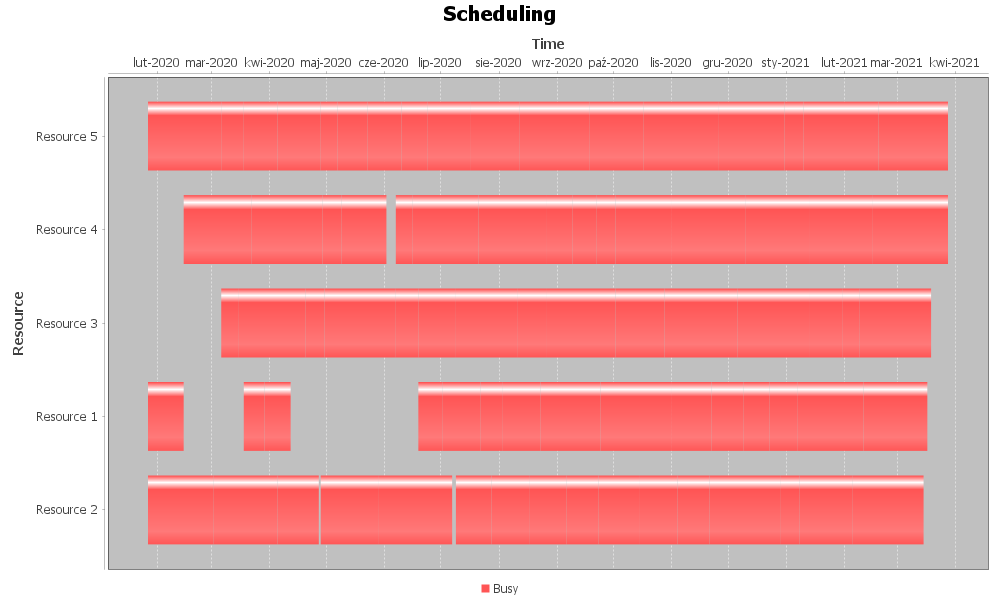

In [5]:
localSearchSolver.getBestSchedule().get().toGraph().createBufferedImage(1000, 600)

Jak widać na powyższej wizualizacji przez część czasu niektóre zasoby nie pracują nad żadnymi zadaniami. Przydatnym wykresem jest również ocena danego rozwiązania zmieniająca się w czasie kolejnych iteracji:

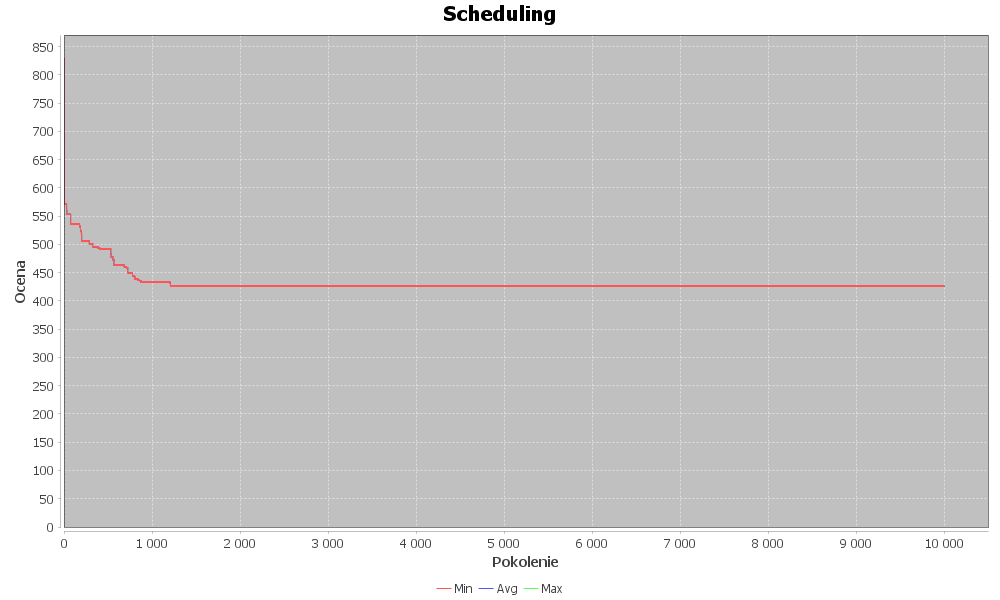

In [6]:
localSearchSolver.toGraph().createBufferedImage(1000, 600)

Jak widać metoda ta dość szybko utyka w pewnym lokalnym minimum i nie potrafi z niego wyjść. Jest to oczekiwany rezultat w związku z tym, że nie posiada ona w sobie żadnych mechanizmów do uniknięcia takiej sytuacji.

## Algorytm zachłanny

Drugim przedstawianym sposobem jest algorytm zachłanny. Można go opisać następująco:
1. Stwórz puste rozwiązanie.
2. Tak długo jak w rozwiązaniu nie ma wszystkich zadań:
    1. Dodaj do rozwiązania takie zdanie wykonywane przez taki zasób które jak najmniej wydłuży czas wykonywania harmonogramu.
3. Zwróć rozwiązanie.

Poziom skomplikowania jest podobny jak przy przeszukiwaniu lokalnym. Jedynym elementem losowym, jest kwestia wyboru nowej części rozwiązania w przypadku remisu na najkrótszy czas. W zwiazku z tym jedyny parametr ilości uruchomień - za każdym razem podejmowany może zostać inny losowy wybór.

In [7]:
int greedyBuilderPopulationSize = 100;
Solver greedyBuilderSolver = new GreedyBuilderAlgorithm(greedyBuilderPopulationSize).prepareSolver(dataset);
greedyBuilderSolver.solve();
greedyBuilderSolver.getBestSchedule().get().getFitness();

430

Rozwiązania uzyskane przez algorytm zachłanny są dla większości zbiorów danych w najlepszym wypadku tak samo dobre jak przez przeszukiwanie lokalne, ale posiada on znacznie mniejsze odchylenie standardowe. Poniżej zaprezentowałem grafikę obrazująca rozkład pracy.

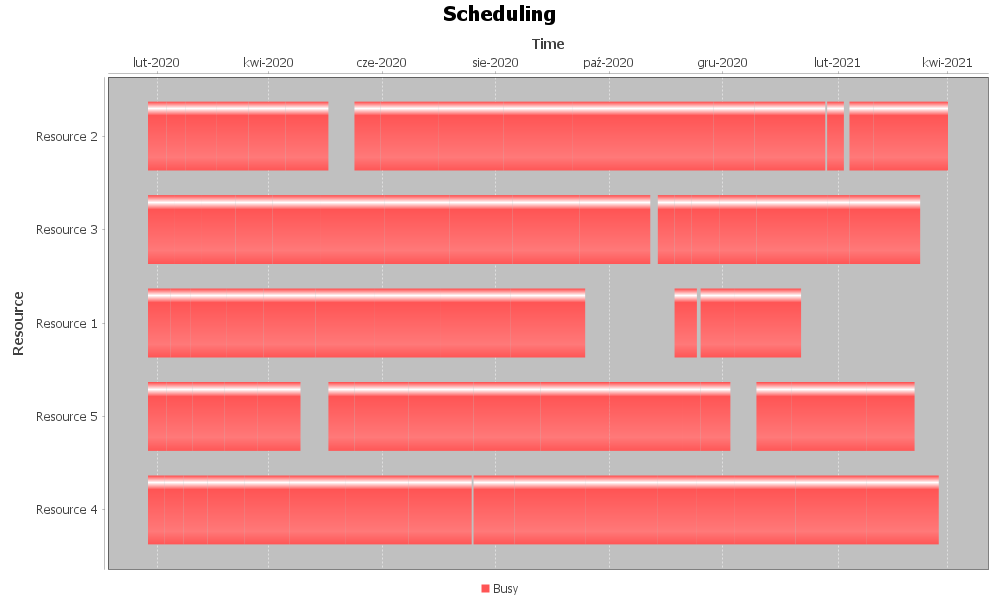

In [8]:
greedyBuilderSolver.getBestSchedule().get().toGraph().createBufferedImage(1000, 600)

Przerwy w pracy dalej występują dla tego algorytmu. W tym wypadku rozwiązanie jest generowane za jednym razem, więc nie dołączyłem wykresu generacji.

# Symulowane wyżarzanie

Trzecia metaheurystyka jest zbliżona w działaniu do przeszukiwania lokalnego z jedną kluczową różnica:
1. Jest ustalona temperatura początkowa.
2. Temperatura w danym momencie jest ilorazem temperatury początkowej i liczby obecnego przebiegu.
3. Jeżeli wygenerowany sąsiad nie jest lepszy od rozwiązania, to posiada szansę na akceptację wyliczaną ze wzoru: 
    
     $$exp(\frac{wartoscOcenyRozwiazania-wartoscOcenySasiada}{biezacaTemperatura})$$
     
Dzięki temu jest coraz mniejsza szansa na akceptacje gorszych rozwiązań, co pozwala na uniknięcie utknięcia w lokalnego minimum.

In [9]:
int simulatedAnnealingPassLimit = 100000;
double maxTemp = 25000;
Solver simulatedAnnealingSolver = new SimulatedAnnealingAlgorithm(simulatedAnnealingPassLimit, maxTemp).prepareSolver(dataset);
simulatedAnnealingSolver.solve();
simulatedAnnealingSolver.getBestSchedule().get().getFitness();

388

Metoda ta osiąga najlepsze wyniki, zarówno pod względem najlepszego, jak i średniego rozwiązania wśród wszystkich zaprezentowanych tutaj

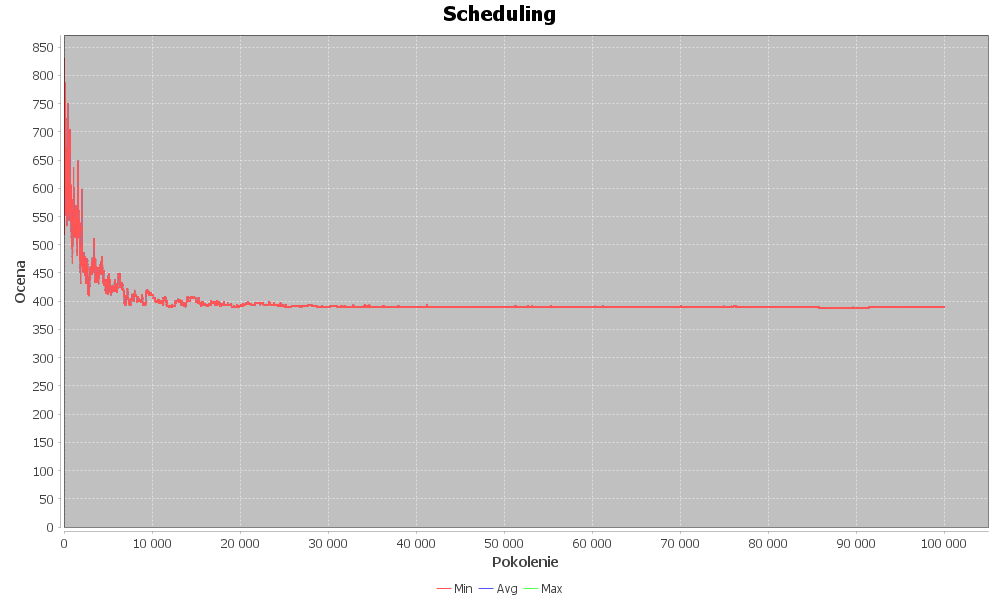

In [10]:
simulatedAnnealingSolver.toGraph().createBufferedImage(1000, 600)

Możemy sobie zobaczyć na wykresie generacji jak temperatura spada i jaki to ma efekt na wygenerowane rozwiązanie.

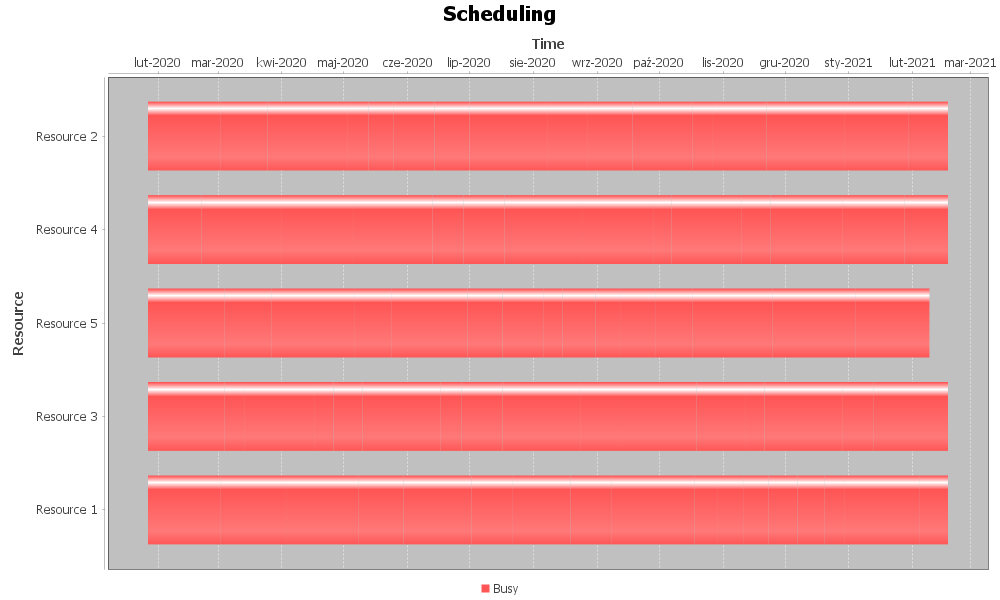

In [11]:
simulatedAnnealingSolver.getBestSchedule().get().toGraph().createBufferedImage(1000, 600)

Jak można zauważyć na wygenerowanej grafice, przerwy w pracy są bardzo małe, albo praktycznie nie występują.

## Algorytm genetyczny

Ostatnia metaheurystyka jest najbardziej skomplikowana. Jest ona inspirowana sposobem działania naturalnej ewolucji wśród żywych organizmów. Można opisać ją w następujący sposób:

1. Wygeneruj określoną liczbę losowych osobników.
2. Powtarzaj przez określoną liczbę iteracji.
    1. Uruchom na generacji po kolei każdy operator genetyczny z określoną szansą.
3. Zwróć najlepsze rozwiązanie.

Jest to bardzo elastyczne i wiele zależy od tego jakie operatory genetyczne zostaną zastowałem. W moim wypadku zdecydowałem się na zastosowanie następujących:

1. Selekcja elitarna - wybierz najlepszego osobnika - nie pozwala to zniknąć najlepszemu rozwiązaniu.
2. Selekcja turniejowa - wybierz określoną liczbę losowych osobników, a potem najlepszego z nich, powtarzając ten cykl tak długo, aż zostanie osiągnięta taką samą liczbę elementów co w pierwotnej generacji - pozwala to odrzucić gorsze rozwiązania, jednak dając im pewną szansę, ponieważ nie zawsze wybierane są tylko najlepsze do turnieju.
3. Krzyżowanie zasobów - wybierz dwa osobniki i z pewną szansą zamień pomiędzy nimi część przydziałów zasobów do zadań - pozwala to generować nowe rozwiązania, które łączą zalety dwóch dobrych osobników, wcześniej wybranych przez selekcję.
4. Krzyżowanie kolejności - działa podobnie, jednak biorąc część kolejności z pierwszego rozwiązania i pozostałą część z drugiego, dzięki czemu unika konfliktów - efekt jak powyżej.
5. Mutacja zasobów - z pewną szansą zamień osobnika z jego sąsiadem pod względem zasobów - pozwala to na eksperymentowanie i szukanie nowych rozwiązań, a w efekcie szanse na uniknięcie lokalnego minimum.
6. Mutacja kolejności - działa podobnie, tylko pod względem kolejności - efekt jak powyżej.

In [12]:
int geneticPopulationSize = 100;
int geneticPassLimit = 1000;
int tournamentSize = 5;
double crossoverChance = 1;
double mutationChance = 0.5;
Solver geneticSolver = new GeneticAlgorithm(geneticPopulationSize, geneticPassLimit, tournamentSize, 
        crossoverChance, mutationChance).prepareSolver(dataset);
geneticSolver.solve();
geneticSolver.getBestSchedule().get().getFitness();

392

Rozwiązania generowane przez algorytm genetyczny są zwykle minimalnie gorsze, niż przez symulowane wyżarzanie dla tego problemu. 

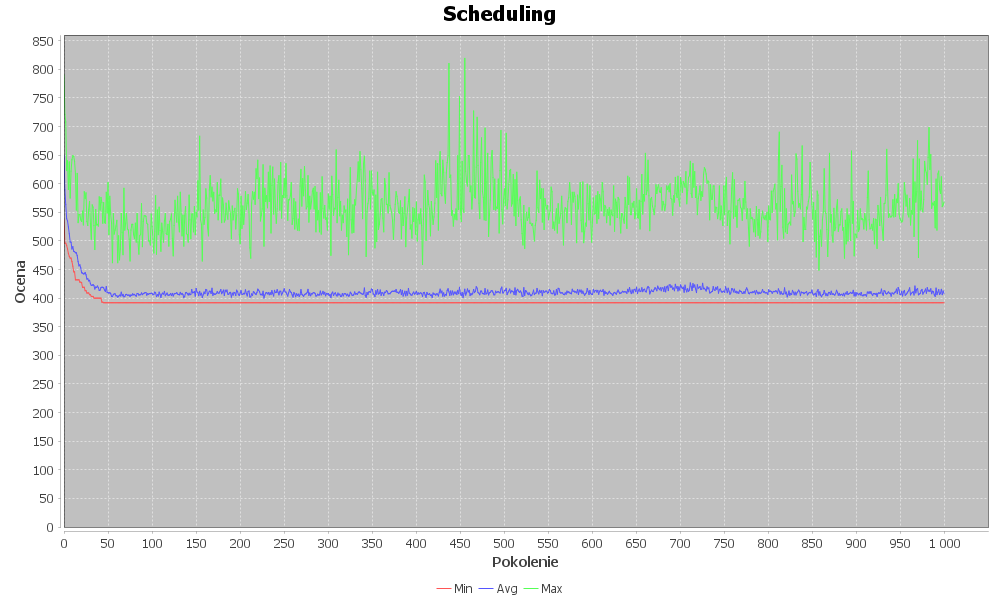

In [13]:
geneticSolver.toGraph().createBufferedImage(1000, 600)

Tym razem na wykresie każdego pokolenia są także średnie i maksymalne wartości. Dzięki temu widać jak spada to w kierunku coraz lepszego rozwiązania. Dodatkowo poprzez wysoką wartość maksymalnej oceny można zauważyć efekt nieudanej mutacji najgorszego osobnika.

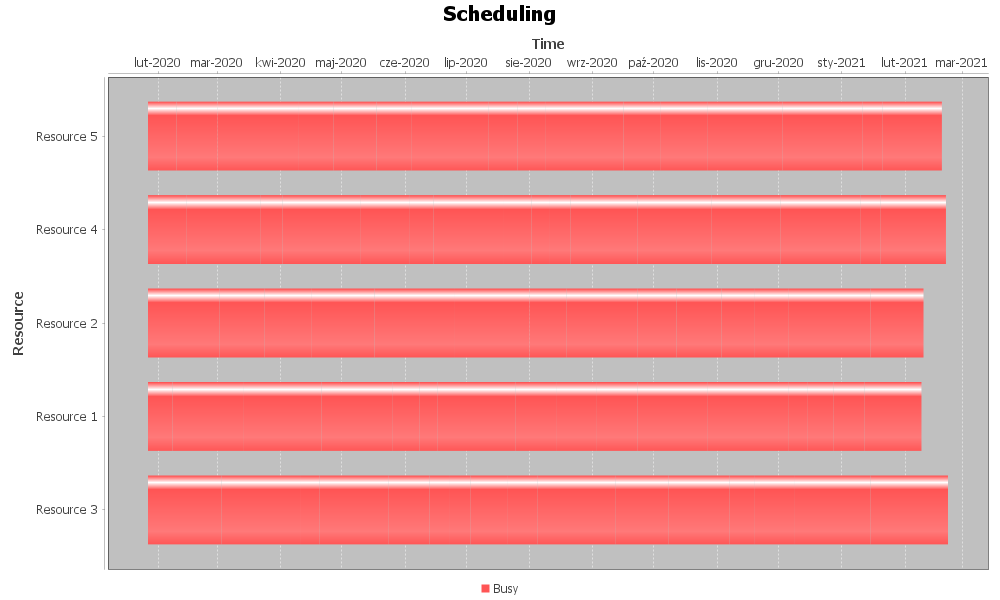

In [14]:
geneticSolver.getBestSchedule().get().toGraph().createBufferedImage(1000, 600)

Przestawienie pracy wygląda ponownie jak w poprzedniej metaheurystyce.

## Podsumowanie

Zastanawiałem się także nad innymi metaheurystykami (algorytmy rojowe - takie jak algorytm roju pszczół, czy algorytm roju cząstek). Niestety jednak wymagają one definicję funkcji odległości pomiędzy dwoma rozwiązaniami. Dla mojej reprezentacji problemu nie jest możliwe, ponieważ nie da się zdefiniować różnicy w przypadku kwestii przydziałów różnych zasobów do zadań.

Każda z podanych wcześniej metaheurystyk uruchomiłem 10 razy, na każdym z dostarczonych przez autorów zbiorze danych. Wyniki przedstawiłem w tabeli poniżej. __Zauwazyłem że w niektórych wersjach Jupyter Notebooka początkowo może się ona nie wczytywać poprawnie. W takim wypadku należy na nią kliknąć, a potem użyć przycisku run powyżej__. Badania zajęły około 9 godzin, przy wykorzystaniu wielowątkowości, na komputerze wyposażonym w procesor Intel i9-9900K o taktowaniu 4,7 ghz.

In [15]:
import java.nio.file.Paths;    
%jars ..//target//msrcpsp-0.2-SNAPSHOT.jar
import it.zerko.msrcpsp.io.InputOutputHelper;
InputOutputHelper inputOutputHelper = new InputOutputHelper();
display(inputOutputHelper.loadResults(Paths.get("../docs/results.txt")), "text/markdown")

Algorithm|Dataset|Minimum|Average|Standard deviation
---|---|---|---|---
LocalSearchAlgorithm|average|325.90697674418607|363.7232558139535|30.38326824017151
GreedyBuilderAlgorithm|average|323.9767441860465|327.7767441860465|2.424857864389769
SimulatedAnnealingAlgorithm|average|296.3488372093023|297.06976744186045|0.5639664568541612
GeneticAlgorithm|average|296.5581395348837|297.8581395348837|0.9791913632735418
GreedyBuilderAlgorithm|100_5_64_9|500.0|508.7|4.808557187163549
GeneticAlgorithm|100_5_64_9|475.0|476.8|1.2292725943057183
LocalSearchAlgorithm|100_5_64_9|480.0|521.1|33.765366871988824
SimulatedAnnealingAlgorithm|100_5_64_9|475.0|475.8|0.632455532033676
GreedyBuilderAlgorithm|200_10_85_15|497.0|501.3|2.0575065816014613
LocalSearchAlgorithm|200_10_85_15|554.0|624.4|60.15941784588308
SimulatedAnnealingAlgorithm|200_10_85_15|474.0|474.0|0.0
GeneticAlgorithm|200_10_85_15|474.0|475.4|0.8432740427115677
GreedyBuilderAlgorithm|100_5_64_15|508.0|514.4|4.3256341860022225
SimulatedAnnealingAlgorithm|100_5_64_15|482.0|482.7|0.48304589153964794
LocalSearchAlgorithm|100_5_64_15|521.0|554.2|37.88227377899413
GeneticAlgorithm|100_5_64_15|482.0|484.4|1.07496769977314
GreedyBuilderAlgorithm|10_5_8_5|80.0|80.0|0.0
SimulatedAnnealingAlgorithm|10_5_8_5|80.0|80.0|0.0
LocalSearchAlgorithm|10_5_8_5|80.0|82.3|4.056544780420347
GeneticAlgorithm|10_5_8_5|80.0|80.0|0.0
GreedyBuilderAlgorithm|200_10_50_15|516.0|520.0|2.211083193570267
LocalSearchAlgorithm|200_10_50_15|510.0|613.1|63.08098850772007
SimulatedAnnealingAlgorithm|200_10_50_15|485.0|485.5|0.5270462766947299
GeneticAlgorithm|200_10_50_15|486.0|486.8|0.6324555320336759
GreedyBuilderAlgorithm|200_20_54_15|296.0|300.7|3.1287200080686173
LocalSearchAlgorithm|200_20_54_15|367.0|406.6|20.748226162467212
SimulatedAnnealingAlgorithm|200_20_54_15|257.0|258.6|0.8432740427115678
GeneticAlgorithm|200_20_54_15|258.0|260.3|1.5670212364724212
GreedyBuilderAlgorithm|10_3_5_3|99.0|99.0|0.0
SimulatedAnnealingAlgorithm|10_3_5_3|93.0|93.0|0.0
LocalSearchAlgorithm|10_3_5_3|93.0|105.6|7.961016127215029
GeneticAlgorithm|10_3_5_3|93.0|94.1|1.3703203194062976
GreedyBuilderAlgorithm|100_5_46_15|620.0|630.4|5.641118880348314
LocalSearchAlgorithm|100_5_46_15|557.0|601.2|41.96241704721553
SimulatedAnnealingAlgorithm|100_5_46_15|529.0|532.1|4.332051092342594
GeneticAlgorithm|100_5_46_15|531.0|534.3|3.6530048514126623
GreedyBuilderAlgorithm|15_9_12_9|90.0|90.0|0.0
SimulatedAnnealingAlgorithm|15_9_12_9|90.0|90.0|0.0
LocalSearchAlgorithm|15_9_12_9|90.0|90.7|2.2135943621178655
GeneticAlgorithm|15_9_12_9|90.0|90.0|0.0
GreedyBuilderAlgorithm|200_40_45_9|155.0|158.3|1.766981104093143
SimulatedAnnealingAlgorithm|200_40_45_9|141.0|141.6|0.6992058987801011
LocalSearchAlgorithm|200_40_45_9|206.0|230.4|17.60807895383379
GeneticAlgorithm|200_40_45_9|138.0|141.1|1.9692073983655907
GreedyBuilderAlgorithm|200_40_133_15|179.0|182.0|1.5634719199411433
LocalSearchAlgorithm|200_40_133_15|202.0|222.8|18.213548070964464
SimulatedAnnealingAlgorithm|200_40_133_15|139.0|140.3|0.9486832980505139
GeneticAlgorithm|200_40_133_15|136.0|137.6|1.5055453054181618
GreedyBuilderAlgorithm|10_7_10_7|104.0|104.0|0.0
LocalSearchAlgorithm|10_7_10_7|104.0|104.0|0.0
SimulatedAnnealingAlgorithm|10_7_10_7|104.0|104.0|0.0
GeneticAlgorithm|10_7_10_7|104.0|104.0|0.0
GreedyBuilderAlgorithm|100_5_22_15|526.0|534.5|5.835713800003866
SimulatedAnnealingAlgorithm|100_5_22_15|485.0|485.7|0.4830458915396479
LocalSearchAlgorithm|100_5_22_15|487.0|530.4|48.256720890577625
GeneticAlgorithm|100_5_22_15|485.0|487.3|1.1595018087284057
GreedyBuilderAlgorithm|100_10_27_9_D2|237.0|241.3|3.056868404829433
LocalSearchAlgorithm|100_10_27_9_D2|226.0|281.1|26.568360464616138
SimulatedAnnealingAlgorithm|100_10_27_9_D2|207.0|208.4|0.8432740427115678
GeneticAlgorithm|100_10_27_9_D2|208.0|210.5|2.173067468400883
GreedyBuilderAlgorithm|100_10_48_15|280.0|283.0|4.320493798938574
SimulatedAnnealingAlgorithm|100_10_48_15|244.0|244.2|0.4216370213557839
LocalSearchAlgorithm|100_10_48_15|262.0|296.6|35.459523090106245
GeneticAlgorithm|100_10_48_15|244.0|246.1|1.5238839267549946
GreedyBuilderAlgorithm|200_20_150_9_D5|900.0|900.0|0.0
SimulatedAnnealingAlgorithm|200_20_150_9_D5|900.0|900.0|0.0
LocalSearchAlgorithm|200_20_150_9_D5|900.0|912.0|21.710212650578374
GeneticAlgorithm|200_20_150_9_D5|900.0|900.0|0.0
GreedyBuilderAlgorithm|200_20_97_15|372.0|374.1|1.197218999737865
LocalSearchAlgorithm|200_20_97_15|336.0|400.7|42.2217690034155
SimulatedAnnealingAlgorithm|200_20_97_15|336.0|336.0|0.0
GeneticAlgorithm|200_20_97_15|336.0|336.0|0.0
GreedyBuilderAlgorithm|15_6_10_6|102.0|102.0|0.0
SimulatedAnnealingAlgorithm|15_6_10_6|102.0|102.0|0.0
LocalSearchAlgorithm|15_6_10_6|102.0|102.0|0.0
GeneticAlgorithm|15_6_10_6|102.0|102.0|0.0
GreedyBuilderAlgorithm|100_5_64_9|504.0|508.3|4.191260749066641
SimulatedAnnealingAlgorithm|100_5_64_9|476.0|476.0|0.0
LocalSearchAlgorithm|100_5_64_9|495.0|527.0|32.145502536643185
GeneticAlgorithm|100_5_64_9|475.0|476.8|1.0327955589886446
GreedyBuilderAlgorithm|200_10_84_9|538.0|543.2|2.8596814119369625
SimulatedAnnealingAlgorithm|200_10_84_9|506.0|506.8|0.6324555320336759
LocalSearchAlgorithm|200_10_84_9|541.0|621.3|67.68727108302319
GeneticAlgorithm|200_10_84_9|507.0|507.5|0.5270462766947299
GreedyBuilderAlgorithm|100_10_47_9|274.0|277.7|2.3118054512532935
LocalSearchAlgorithm|100_10_47_9|272.0|299.3|29.390285621083862
SimulatedAnnealingAlgorithm|100_10_47_9|253.0|253.7|0.4830458915396479
GeneticAlgorithm|100_10_47_9|253.0|254.9|1.1972189997378646
GreedyBuilderAlgorithm|100_5_20_9_D3|428.0|433.1|3.4140233677518315
SimulatedAnnealingAlgorithm|100_5_20_9_D3|387.0|387.9|0.31622776601683794
LocalSearchAlgorithm|100_5_20_9_D3|402.0|438.2|27.56729140767289
GeneticAlgorithm|100_5_20_9_D3|387.0|388.3|1.0593499054713804
GreedyBuilderAlgorithm|100_20_65_15|205.0|205.0|0.0
SimulatedAnnealingAlgorithm|100_20_65_15|205.0|205.0|0.0
LocalSearchAlgorithm|100_20_65_15|205.0|229.3|23.513825720201297
GeneticAlgorithm|100_20_65_15|205.0|205.0|0.0
GreedyBuilderAlgorithm|200_40_90_9|165.0|169.8|2.3475755815545343
LocalSearchAlgorithm|200_40_90_9|203.0|235.3|25.113298823089288
SimulatedAnnealingAlgorithm|200_40_90_9|137.0|139.3|1.4944341180973264
GeneticAlgorithm|200_40_90_9|135.0|138.3|1.7029386365926402
GreedyBuilderAlgorithm|100_5_48_9|513.0|518.5|3.5668224265054493
SimulatedAnnealingAlgorithm|100_5_48_9|491.0|491.6|0.5163977794943223
LocalSearchAlgorithm|100_5_48_9|509.0|526.8|15.859101838096352
GeneticAlgorithm|100_5_48_9|492.0|493.5|0.8498365855987975
GreedyBuilderAlgorithm|200_40_130_9_D4|513.0|513.0|0.0
LocalSearchAlgorithm|200_40_130_9_D4|513.0|539.7|48.73522568145368
SimulatedAnnealingAlgorithm|200_40_130_9_D4|513.0|513.0|0.0
GeneticAlgorithm|200_40_130_9_D4|513.0|513.0|0.0
GreedyBuilderAlgorithm|200_10_135_9_D6|589.0|596.2|4.613988392799541
SimulatedAnnealingAlgorithm|200_10_135_9_D6|534.0|534.0|0.0
LocalSearchAlgorithm|200_10_135_9_D6|630.0|705.3|59.07819676778679
GeneticAlgorithm|200_10_135_9_D6|534.0|534.0|0.0
GreedyBuilderAlgorithm|100_20_22_15|157.0|159.4|1.429840705968481
SimulatedAnnealingAlgorithm|100_20_22_15|126.0|127.3|0.9486832980505138
LocalSearchAlgorithm|100_20_22_15|162.0|185.2|22.748870545833945
GeneticAlgorithm|100_20_22_15|127.0|128.9|1.4491376746189437
GreedyBuilderAlgorithm|200_40_45_15|170.0|170.9|0.5676462121975467
SimulatedAnnealingAlgorithm|200_40_45_15|159.0|159.0|0.0
LocalSearchAlgorithm|200_40_45_15|188.0|221.6|20.52748834557647
GeneticAlgorithm|200_40_45_15|159.0|159.0|0.0
GreedyBuilderAlgorithm|15_3_5_3|230.0|230.0|0.0
LocalSearchAlgorithm|15_3_5_3|230.0|230.0|0.0
SimulatedAnnealingAlgorithm|15_3_5_3|230.0|230.0|0.0
GeneticAlgorithm|15_3_5_3|230.0|230.0|0.0
GreedyBuilderAlgorithm|100_20_65_9|149.0|153.2|1.9321835661585915
LocalSearchAlgorithm|100_20_65_9|171.0|191.0|17.688665548562135
SimulatedAnnealingAlgorithm|100_20_65_9|125.0|125.5|0.5270462766947299
GeneticAlgorithm|100_20_65_9|126.0|128.3|1.766981104093143
GreedyBuilderAlgorithm|100_20_23_9_D1|172.0|172.0|0.0
LocalSearchAlgorithm|100_20_23_9_D1|172.0|224.4|45.33872516955015
SimulatedAnnealingAlgorithm|100_20_23_9_D1|172.0|172.0|0.0
GeneticAlgorithm|100_20_23_9_D1|172.0|172.0|0.0
GreedyBuilderAlgorithm|200_20_97_9|273.0|276.1|2.183269719175042
SimulatedAnnealingAlgorithm|200_20_97_9|241.0|242.3|0.9486832980505139
LocalSearchAlgorithm|200_20_97_9|298.0|353.2|38.23843325474748
GeneticAlgorithm|200_20_97_9|241.0|243.2|1.5491933384829668
GreedyBuilderAlgorithm|100_10_65_15|295.0|299.7|3.4657049948186747
SimulatedAnnealingAlgorithm|100_10_65_15|243.0|244.2|0.632455532033676
LocalSearchAlgorithm|100_10_65_15|254.0|310.4|36.854669536799086
GeneticAlgorithm|100_10_65_15|245.0|246.0|0.816496580927726
GreedyBuilderAlgorithm|100_20_47_9|164.0|168.4|2.065591117977289
LocalSearchAlgorithm|100_20_47_9|164.0|200.1|29.76369899353536
SimulatedAnnealingAlgorithm|100_20_47_9|124.0|125.1|0.8755950357709131
GeneticAlgorithm|100_20_47_9|125.0|125.6|0.8432740427115678
GreedyBuilderAlgorithm|200_20_145_15|280.0|286.0|2.9059326290271157
SimulatedAnnealingAlgorithm|200_20_145_15|236.0|236.9|0.7378647873726218
LocalSearchAlgorithm|200_20_145_15|275.0|323.6|27.45986970916731
GeneticAlgorithm|200_20_145_15|236.0|237.4|1.5055453054181618
GreedyBuilderAlgorithm|200_10_128_15|539.0|549.1|7.936553968120477
LocalSearchAlgorithm|200_10_128_15|514.0|586.8|47.63938613281148
SimulatedAnnealingAlgorithm|200_10_128_15|460.0|460.9|0.31622776601683794
GeneticAlgorithm|200_10_128_15|461.0|463.4|2.3664319132398464
GreedyBuilderAlgorithm|200_40_91_15|181.0|181.9|0.7378647873726218
SimulatedAnnealingAlgorithm|200_40_91_15|132.0|135.0|1.632993161855452
LocalSearchAlgorithm|200_40_91_15|213.0|242.0|26.49528259898354
GeneticAlgorithm|200_40_91_15|131.0|133.5|1.4337208778404378
GreedyBuilderAlgorithm|100_20_46_15|191.0|196.9|3.1428932176861784
SimulatedAnnealingAlgorithm|100_20_46_15|161.0|163.7|2.3593784492248515
LocalSearchAlgorithm|100_20_46_15|193.0|214.9|20.046889478863744
GeneticAlgorithm|100_20_46_15|165.0|167.0|1.7638342073763937
GreedyBuilderAlgorithm|100_10_26_15|270.0|280.3|7.557924465236619
SimulatedAnnealingAlgorithm|100_10_26_15|234.0|234.1|0.316227766016838
LocalSearchAlgorithm|100_10_26_15|272.0|308.8|37.37140915489035
GeneticAlgorithm|100_10_26_15|235.0|236.1|0.9944289260117531
GreedyBuilderAlgorithm|200_10_50_9|501.0|503.3|1.3374935098492586
SimulatedAnnealingAlgorithm|200_10_50_9|486.0|486.0|0.0
LocalSearchAlgorithm|200_10_50_9|507.0|616.5|84.0214919595642
GeneticAlgorithm|200_10_50_9|486.0|487.1|0.7378647873726218
GreedyBuilderAlgorithm|100_10_64_9|292.0|298.2|3.3266599866332394
LocalSearchAlgorithm|100_10_64_9|258.0|292.3|17.47410782971321
SimulatedAnnealingAlgorithm|100_10_64_9|242.0|242.8|0.6324555320336759
GeneticAlgorithm|100_10_64_9|242.0|243.9|1.1005049346146119
GreedyBuilderAlgorithm|200_20_55_9|277.0|280.5|2.4608038433722332
SimulatedAnnealingAlgorithm|200_20_55_9|247.0|248.0|0.6666666666666666
LocalSearchAlgorithm|200_20_55_9|296.0|337.9|23.853487981611597
GeneticAlgorithm|200_20_55_9|248.0|248.5|0.7071067811865476

d40764b2-96df-4682-a05e-8ffca44d8d8e

Tak jak wcześniej wspominałem, najlepsze wyniki osiągane są przez symulowane wyżarzanie, a drugi w kolejności jest algorytm genetyczny. Obie te metody są skuteczniejsze niż przeszukiwanie lokalne, czy algorytm zachłanny. W związku z tym można uznać, że są one dobrymi sposobami na uzyskanie jak najlepszych harmonogramów dla projektów.